In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import shapely.wkt
import pyproj
from pyproj import Geod
import shapely
from shapely.geometry import box, Polygon, Point
from shapely.ops import orient
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
import pickle
import matplotlib

## 0. Specify Filepaths and Preprocessing

In [2]:
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
OUTPUT_FP = os.path.join(OAK_FP, 'outputs/Population-Estimates/final/')
cf_fp = '/oak/stanford/groups/deho/building_compliance/CloudFactory/'
plots_fp = os.path.join(OAK_FP, 'outputs/journal_plots/')

In [3]:
df_processed = pd.read_csv(os.path.join(cf_fp, 'results', 'Batch3', 'processed_buildings.csv'), dtype={'apn': str})

wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:26910')
project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform

df_processed['2016_a'] = df_processed['2016'].apply(lambda x: shapely.ops.transform(project, 
                                                                                    shapely.wkt.loads(x)).area if not pd.isna(x) else x)
df_processed['2020_a'] = df_processed['2020'].apply(lambda x: shapely.ops.transform(project, 
                                                                                    shapely.wkt.loads(x)).area if not pd.isna(x) else x)
subset = df_processed[(df_processed['2016_a'] >= 11.15) | (df_processed['2020_a'] >= 11.15)]

## Fig 1 (left): Population Estimate

In [4]:
bins = pd.read_csv(os.path.join(OUTPUT_FP, '../outputs/Strata/sj_parcels_bins.csv'))
bins_sample = pd.read_csv(os.path.join(OUTPUT_FP, '../CloudFactory/Iteration3/complete_sampled_APNs.csv'))

In [5]:
bin_n = bins['Bin'].value_counts()
bin_sample_n = bins_sample['Bin'].value_counts()

unique_bins = list(bins['Bin'].unique())
sampled_unique_bins = list(bins_sample['Bin'].unique())

merged = subset[['apn', '2016', '2020']].merge(bins, left_on='apn', right_on='APN', how='left').drop(columns=['apn'])

In [6]:
results = {}
results_df = pd.DataFrame(columns=['bin', 'year', 't', 'ybar', 'N', 'n', 'var', 'tot_var', 'high'])
for year in ['2016', '2020']:
    total = 0
    total_var = 0
    
    for b in unique_bins:
        if b in sampled_unique_bins: # we drop 2 bins
            high_income = False
            income = b.split('_')[1].split('-')[0]
            
            sub = merged[merged['Bin'] == b]
            sub[year] = sub[year].apply(lambda x: 1 if not pd.isna(x) else 0)
            sub = sub[[year, 'APN']].groupby('APN').agg(list)
            sub[year] = sub[year].apply(lambda x: np.sum(x))

            n_j = bin_sample_n[b]
            N_j = bin_n[b]

            y_avg_j = sub[year].sum()/n_j
            t_j = N_j*y_avg_j
            if n_j == 1:
                n_j += 1 # safeguard against div by 0 error
            var_j = np.sum(np.square(np.array(sub[year].tolist() + \
                                          [0] * (n_j-len(sub))) - y_avg_j)) / (n_j - 1)
            total_var_j = (1-(n_j/N_j))*N_j*N_j*(var_j/n_j)

            total += t_j
            total_var += total_var_j
            
            results_df.loc[len(results_df)] = [b, year, t_j, y_avg_j, N_j, n_j, var_j, total_var_j, high_income]
            
    results[year] = {'t': total, 'var': total_var}


<ipython-input-6-32856b769587>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[year] = sub[year].apply(lambda x: 1 if not pd.isna(x) else 0)


In [7]:
results_df.to_csv(os.path.join(OUTPUT_FP, 'batch3', 'bin_estimates.csv'), index=False)

In [11]:
def plot_q1_left(results, savefig):
    x = list(results.keys())
    t = [results['2016']['t'], results['2020']['t']]
    var = [results['2016']['var'], results['2020']['var']]
    CI = np.sqrt(var)*1.96
    
    plt.figure(figsize=(8, 6))
    plt.bar(x, t, yerr=CI, align='center', ecolor='black', capsize=10)
    plt.xlabel('Year')
    plt.ylabel('Est. number of ADUs')
    plt.ylim([15000, 25000])
    plt.savefig(savefig, bbox_inches='tight')
    plt.show()

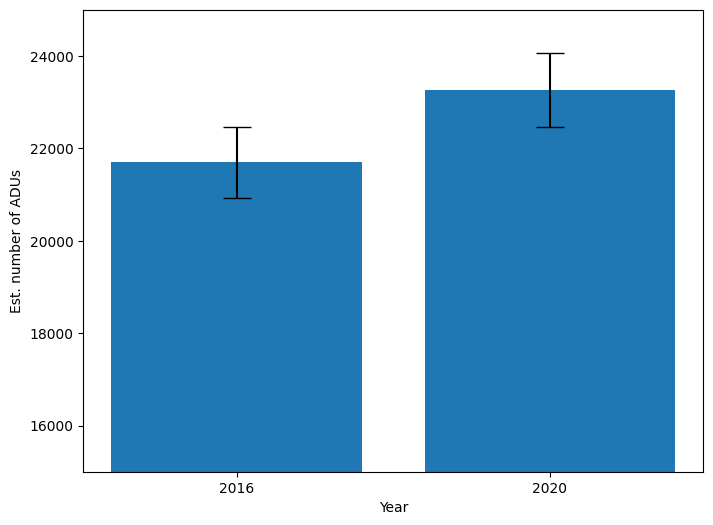

In [12]:
plot_q1_left(results, os.path.join(plots_fp, 'q1_left.pdf'))

## Fig 1 (right): Bootstrap Test (t20-t16 > 0)

Helper functions

In [13]:
def make_global(bins_all_res, bins_sample, merged):
    global bins_all_res_global
    global merged_global
    global bins_sample_global

    bins_all_res_global = bins_all_res
    merged_global = merged
    bins_sample_global = bins_sample
    
def driver(i):
    bin_n = bins_all_res_global['Bin'].value_counts()
    bin_sample_n = bins_sample_global['Bin'].value_counts()
    unique_bins = list(bins_all_res_global['Bin'].unique())
    sampled_unique_bins = list(bins_sample_global['Bin'].unique())
    
    results = {}
    for year in ['2016', '2020']:

        total = 0
        total_var = 0

        for b in unique_bins:
            if b in sampled_unique_bins: # we drop 2 bins
                # SAMPLE WITH REPLACEMENT HERE
                np.random.seed((os.getpid() * int(time.time())) % 123456789)
                bootstrap = bins_sample_global[bins_sample_global['Bin'] == b].sample(frac=1.0, replace=True)
                value_counts = bootstrap['APN'].value_counts()

                overlap = list(set(bootstrap['APN'].unique()) & set(merged_global['APN'].unique()))
                overlap_counts = value_counts.loc[overlap]
                sub = pd.DataFrame(columns=merged_global.columns)

                for idx, val in overlap_counts.iteritems():
                    for i in range(val):
                        sub.loc[len(sub)] = merged_global[merged_global['APN'] == idx].iloc[0].tolist()

                sub[year] = sub[year].apply(lambda x: 1 if not pd.isna(x) else 0)
                sub = sub[[year, 'APN']].groupby('APN').agg(list)
                sub[year] = sub[year].apply(lambda x: np.sum(x))

                n_j = bin_sample_n[b]
                N_j = bin_n[b]

                y_avg_j = sub[year].sum()/n_j
                t_j = N_j*y_avg_j
                if n_j == 1:
                    n_j += 1 # safeguard against div by 0 error
                var_j = np.sum(np.square(np.array(sub[year].tolist() + \
                                              [0] * (n_j-len(sub))) - y_avg_j)) / (n_j - 1)
                total_var_j = (1-(n_j/N_j))*N_j*N_j*(var_j/n_j)

                total += t_j
                total_var += total_var_j

        results[year] = {'t': total, 'var': total_var}

    return results['2020']['t'] - results['2016']['t']

def bootstrap_mp(subset, bins_all_res, bins_sample, n):
    
    merged = subset[['apn', '2016', '2020']].merge(bins_all_res, left_on='apn', 
                                                   right_on='APN', how='left').drop(columns=['apn'])
    
    nprocs = mp.cpu_count()

    p = mp.Pool(processes=nprocs, initializer=make_global, 
                initargs=(bins_all_res, bins_sample, merged, ))
    
#     result = p.map(driver, range(n))
    
    result = []
    for x in tqdm(p.imap_unordered(driver, range(n)), total=n):
        result.append(x)
    
    return result

def two_sided_test(l, p):
    l.sort()
    ci = [l[int(p/2*len(l))], l[len(l) - int(p/2*len(l))]]
    mean = np.mean(l)
    return mean, ci

def one_sided_test(l, p):
    l.sort()
    lb = l[int(p*len(l))]
    return lb

**The folloiwng code takes 2++ hrs, please DON'T run**

In [22]:
n = 5000
diff_n = bootstrap_mp(subset, bins, bins_sample, n)

with open(os.path.join(OUTPUT_FP, "bootstrap_q1.p"), "wb") as output_file:
    pickle.dump(diff_n, output_file)

100%|██████████| 5000/5000 [2:21:48<00:00,  1.70s/it]  


**START HERE INSTEAD**

In [4]:
with open(os.path.join(OUTPUT_FP, "bootstrap_q1.p"), "rb") as output_file:
    diff_n = pickle.load(output_file)

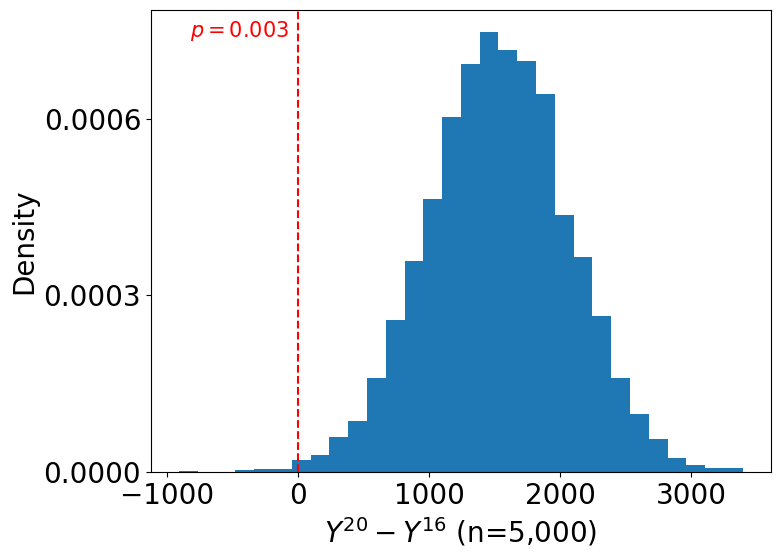

In [88]:
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(8, 6))
plt.hist(diff_n, bins=30, density=True)
plt.axvline(x=0, linestyle='--', color='r')
plt.text(-450, 0.00075, f'$p=0.003$', ha='center', va='center', size='15', color='r')
plt.xlabel('$Y^{20}-Y^{16}$ (n=5,000)')
plt.ylabel('Density')
plt.yticks([0.0000, 0.0003, 0.0006])
plt.savefig(os.path.join(plot_fp, 'q1_right.pdf'), bbox_inches='tight')
plt.show()

In [7]:
two_sided_test(diff_n, 0.05)

(1527.095221340588, [472.1294420752529, 2571.4674599569407])

In [9]:
one_sided_test(diff_n, 0.05)

652.6931007592175